# # **Imorting required libraries  - python, pandas, tensorflow and keras**

In [108]:
#Importing required python libraries - pandas, tensorflow and keras

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import tensorflow as tf
from keras.layers import Activation, Dense
from datetime import datetime
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras import activations

%matplotlib inline 

In [2]:
# Loading the dataset

path = '../input/english-converted-datasets'
items = pd.read_csv(path+'/items.csv')
item_cats = pd.read_csv(path+'/item_categories.csv')
shops = pd.read_csv(path+'/shops.csv')
sales = pd.read_csv(path+'/sales_train.csv')
test = pd.read_csv(path+'/test.csv')
submission = pd.read_csv(path+'/sample_submission.csv')

print("Dataset loaded successfully.")

Dataset loaded successfully.


# **Exploratory Data Analysis**

In [3]:
# Sales_train info

print ('number of shops: ', sales['shop_id'].max())
print ('number of items: ', sales['item_id'].max())
num_month = sales['date_block_num'].max()
print ('number of month: ', num_month)
print ('size of train: ', sales.shape)
sales.head()

number of shops:  59
number of items:  22169
number of month:  33
size of train:  (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# Sales data

sales['year'] = pd.to_datetime(sales['date']).dt.strftime('%Y')
sales['month'] = sales.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%m')) 

sales.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.0,1.0,2013,01
1,03.01.2013,0,25,2552,899.0,1.0,2013,01


<AxesSubplot:xlabel='month', ylabel='item_cnt_day'>

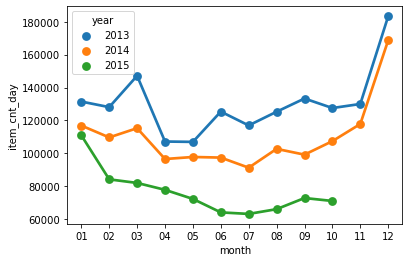

In [5]:
# Examine the data by plotting

grouped = pd.DataFrame(sales.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=grouped)

<AxesSubplot:xlabel='month', ylabel='item_price'>

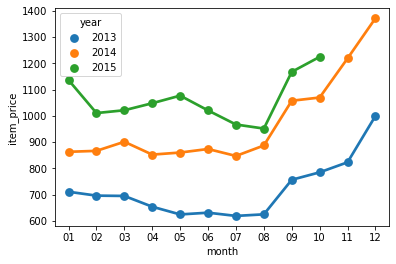

In [6]:
# Sales data - price info and its analysis

grouped_price = pd.DataFrame(sales.groupby(['year','month'])['item_price'].mean().reset_index())
sns.pointplot(x='month', y='item_price', hue='year', data=grouped_price)

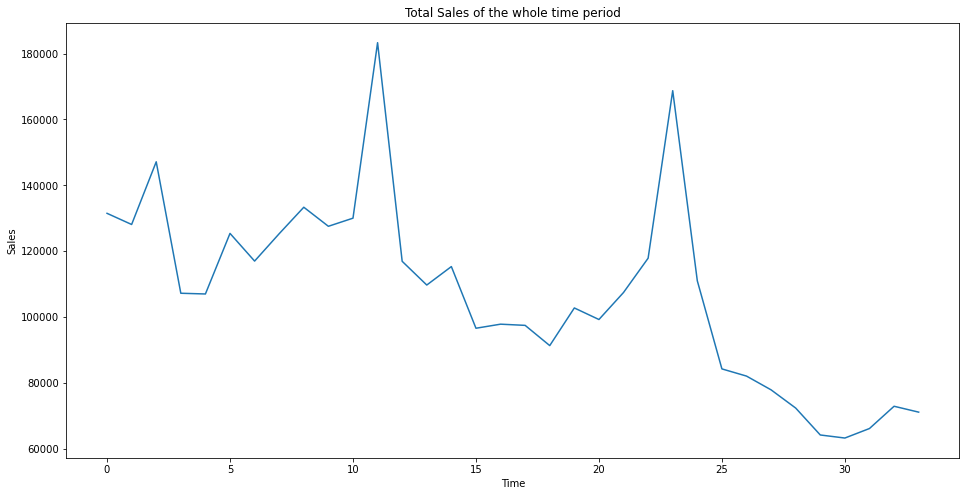

In [7]:
# From the above graph, In every year last two moths are having more slaes
# So in 2015 - expecting more sales

ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the whole time period')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

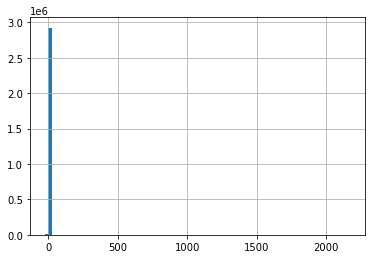

In [8]:
#Sales - items describe

sales.item_cnt_day.hist(bins=100)
sales.item_cnt_day.describe()

# **Data Preparation - Cleaning, filtering, Removing outliers**

In [9]:
# Cleaning the data

print('Dataset size before cleaning:', sales.shape)
sales = sales.query('item_price > 0')
print('Dataset size after cleaning:', sales.shape)

Dataset size before cleaning: (2935849, 8)
Dataset size after cleaning: (2935848, 8)


In [10]:
# Filtering

print('Dataset size before filter:', sales.shape)
# Only shops that exist in test set.
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]
# Only items that exist in test set.
sales = sales[sales['item_id'].isin(test['item_id'].unique())]
print('Dataset size after filter', sales.shape)

Dataset size before filter: (2935848, 8)
Dataset size after filter (1224439, 8)


In [11]:
#Removing of outliers

print('Dataset size before remove outliers:', sales.shape)
sales = sales.query('item_cnt_day >= 0 and item_cnt_day <= 125 and item_price < 75000')
print('Dataset size after remove outliers:', sales.shape)

Dataset size before remove outliers: (1224439, 8)
Dataset size after remove outliers: (1221451, 8)


In [12]:
#Aggregate to monthly level the sales

warnings.filterwarnings("ignore")
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date_block_num","date","item_price","item_cnt_day"].agg({"date_block_num":'mean',"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

monthly_sales.head(5)

date_block_num        date              \
                                         mean         min         max   
date_block_num shop_id item_id                                          
0              2       33                   0  05.01.2013  05.01.2013   
                       482                  0  16.01.2013  16.01.2013   
                       491                  0  09.01.2013  09.01.2013   
                       839                  0  22.01.2013  22.01.2013   
                       1007                 0  11.01.2013  25.01.2013   

                               item_price item_cnt_day  
                                     mean          sum  
date_block_num shop_id item_id                          
0              2       33           499.0          1.0  
                       482         3300.0          1.0  
                       491          600.0          1.0  
                       839         3300.0          1.0  
                       1007         449.0          3.0

In [13]:
# Reset of index , merging of valid data and filling NAN with 0

sales_data_flat = monthly_sales.item_cnt_day.apply(list).reset_index()
#Keep only the test data of valid
sales_data_flat = pd.merge(test,sales_data_flat,on = ['item_id','shop_id'],how = 'left')
#fill na with 0
sales_data_flat.fillna(0,inplace = True)
sales_data_flat.drop(['shop_id','item_id'],inplace = True, axis = 1)
sales_data_flat.head(20)

,ID,date_block_num,sum
0,0,20.0,1.0
1,0,22.0,1.0
2,0,23.0,2.0
3,0,24.0,2.0
4,0,28.0,1.0
5,0,29.0,1.0
6,0,30.0,1.0
7,0,31.0,3.0
8,0,32.0,1.0
9,1,0.0,0.0


# **Pivot table**

In [14]:
# creating of pivot table
# Rows = each shop+item code
# Columns will be out time sequence
dataset = sales_data_flat.pivot_table(index='ID', columns='date_block_num',fill_value = 0,aggfunc='sum' )
dataset.head()

sum                                               ...       \
date_block_num 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0   ... 24.0   
ID                                                                ...        
0                 0    0    0    0    0    0    0    0    0    0  ...    2   
1                 0    0    0    0    0    0    0    0    0    0  ...    0   
2                 0    0    0    0    0    0    0    0    0    0  ...    0   
3                 0    0    0    0    0    0    0    0    0    0  ...    0   
4                 0    0    0    0    0    0    0    0    0    0  ...    0   

                                                             
date_block_num 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0  
ID                                                           
0                 0    0    0    1    1    1    3    1    0  
1                 0    0    0    0    0    0    0    0    0  
2                 0    0    0    3    2    0    1    3    1  
3                 0    0    0    0    0    0    1    0    0  
4                 0    0    0    0    0    0    0    0    0  

[5 rows x 34 columns]

# **Splitting dataset - Train & Test datasets**

In [84]:
# Lets create feature and label sets from the above data

# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)

# Last column is our prediction
y_train = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

# Last column is our prediction
y_test = dataset.values[:,-1:]

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

#print(X_train.shape[0],X_train.shape[1],X_train.shape[2])

(214200, 33, 1) (214200, 1) (214200, 33, 1) (214200, 1)


# **Multilayer Perceptron - MLP Model**

In [32]:
# MLP for Time Series Forecasting (Multilayer Perceptron )
adam = optimizers.Adam()

mlp_model = Sequential()
#mlp_model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
mlp_model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
mlp_model.add(Dropout(0.45))

mlp_model.add(Dense(100))
mlp_model.add(Activation('sigmoid'))
mlp_model.add(Dropout(0.45))

mlp_model.add(Dense(1))
mlp_model.add(Activation('sigmoid'))
mlp_model.add(Dropout(0.4))

mlp_model.summary()


#Compiling model
mlp_model.compile(loss='mse', optimizer='adam', metrics=['accuracy','mean_squared_error','mean_absolute_error'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 33, 100)           200       
_________________________________________________________________
dropout_9 (Dropout)          (None, 33, 100)           0         
_________________________________________________________________
dense_10 (Dense)             (None, 33, 100)           10100     
_________________________________________________________________
activation_6 (Activation)    (None, 33, 100)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 33, 100)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 33, 1)             101       
_________________________________________________________________
activation_7 (Activation)    (None, 33, 1)            

In [33]:
#Model-fitting

#ytrain = y_train.reshape((-1, y_train.shape[1], 1))
#ytrain=np.expand_dims(y_train, axis=-1)
mlp_train = mlp_model.fit(X_train, y_train, epochs=10, batch_size=4096)

Epoch 1/10
53/53 [==============================] - 25s 452ms/step - loss: 4.9264 - accuracy: 0.6949 - mean_squared_error: 4.9264 - mean_absolute_error: 0.4751
Epoch 2/10
53/53 [==============================] - 24s 449ms/step - loss: 8.8230 - accuracy: 0.8452 - mean_squared_error: 8.8230 - mean_absolute_error: 0.3782
Epoch 3/10
53/53 [==============================] - 23s 439ms/step - loss: 3.9592 - accuracy: 0.8493 - mean_squared_error: 3.9592 - mean_absolute_error: 0.3564
Epoch 4/10
53/53 [==============================] - 24s 450ms/step - loss: 5.5170 - accuracy: 0.8473 - mean_squared_error: 5.5170 - mean_absolute_error: 0.3702
Epoch 5/10
53/53 [==============================] - 24s 445ms/step - loss: 6.1592 - accuracy: 0.8507 - mean_squared_error: 6.1592 - mean_absolute_error: 0.3627
Epoch 6/10
53/53 [==============================] - 24s 448ms/step - loss: 5.8486 - accuracy: 0.8506 - mean_squared_error: 5.8486 - mean_absolute_error: 0.3655
Epoch 7/10
53/53 [======================

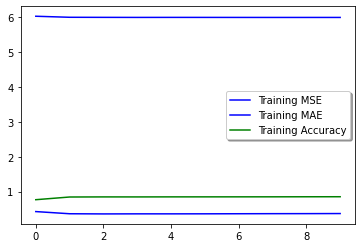

In [34]:
# Plot the loss and accuracy curves - Train data

plt.plot(mlp_train.history['mean_squared_error'], color='b', label="Training MSE")
plt.plot(mlp_train.history['mean_absolute_error'], color='b', label="Training MAE")
plt.plot(mlp_train.history['accuracy'], color='g', label="Training Accuracy")
plt.legend(loc='best', shadow=True)

In [104]:
# Now lets do the prediction without labels

mlp_prediction = mlp_model.predict(X_test)
print('Prediction values size: ',mlp_prediction.shape)

Prediction values size:  (214200, 33, 1)


In [105]:
# Transforming the above prediction arrays to normal data frames

# Actual values
mlp_actual_values = y_test.clip(0,40)
mlp_actual_values = pd.DataFrame({'item_cnt_month':mlp_actual_values.ravel()})
mlp_actual_values.rename(columns = {'item_cnt_month':'Actual'}, inplace = True)

# Prediction Values
mlp_prediction = mlp_prediction.clip(0,40)
mlp_pred_values = pd.DataFrame({'item_cnt_month':mlp_prediction.ravel()})
mlp_pred_values.rename(columns = {'item_cnt_month':'Predict'}, inplace = True)

print('Actual values size: ',mlp_actual_values.shape)
mlp_pred = mlp_pred_values[0:214200]
print('Prediction values size: ',mlp_pred.shape)


lstm_result = pd.concat([mlp_actual_values,mlp_pred],axis=1)
lstm_result.head()

Actual values size:  (214200, 1)
Prediction values size:  (214200, 1)


,Actual,Predict
0,0,0.114221
1,0,0.114221
2,1,0.114221
3,0,0.114221
4,0,0.114221


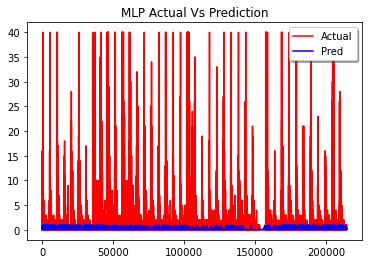

In [106]:
# Plot graph MLP - Actual Vs Prediction Values

plt.title("MLP Actual Vs Prediction")
plt.plot(mlp_actual_values, color='r', label="Actual")
plt.legend(loc='best', shadow=True)

plt.plot(mlp_pred, color='b', label="Pred")
plt.legend(loc='best', shadow=True)

In [46]:
#MLP - Metrics

from sklearn import metrics
from prettytable import PrettyTable
mlp_prediction = np.argmax(mlp_pred, axis=1)

#tp - true positive
#tn - true negative
#fp - false positive
#fn - false negative

# accuracy: (tp + tn) / (p + n)
#Accuracy:
accuracy = round((accuracy_score(mlp_actual_values, mlp_prediction))*100, 2)
#print('MLP-Accuracy: ',accuracy,'%')


# precision tp / (tp + fp)
#Precision:
precision = round(precision_score(mlp_actual_values, mlp_prediction, pos_label='positive', average='weighted')*100, 2)
#print('MLP-Precision_score: ',precision,'%')


# recall: tp / (tp + fn)
#Recall:
recall = round(recall_score(mlp_actual_values, mlp_prediction, pos_label='positive', average='micro')*100, 2)
#print('MLP-Recall_score: ',recall,'%')


# f1: 2 tp / (2 tp + fp + fn)
#f1 score
f1 = round(f1_score(mlp_actual_values, mlp_prediction, pos_label='positive', average='weighted')*100, 2)
#print('MLP-F1_score: ',f1,'%')


Mlp_Table = PrettyTable(['MLP Metrics', '%'])

# Add rows
Mlp_Table.add_row(['MLP-Accuracy ',accuracy])
Mlp_Table.add_row(['MLP-Precision',precision])
Mlp_Table.add_row(['MLP-Recall   ',recall])
Mlp_Table.add_row(['MLP-F1_score ',f1])
#myTable.add_row(['MLP_Confusion_Matrix',matrix])
 
print(Mlp_Table)

#Confusion Matrix
matrix = confusion_matrix(mlp_actual_values, mlp_prediction)
print('MLP_Confusion_Matrix: ',matrix)

+---------------+--------+
|  MLP Metrics  |   %    |
+---------------+--------+
| MLP-Accuracy  | 57.56% |
| MLP-Precision | 49.72% |
| MLP-Recall    | 58.69% |
| MLP-F1_score  | 57.43% |
+---------------+--------+
MLP_Confusion_Matrix:  [[185529      0      0 ...      0      0      0]
 [ 19281      0      0 ...      0      0      0]
 [  4849      0      0 ...      0      0      0]
 ...
 [     1      0      0 ...      0      0      0]
 [     1      0      0 ...      0      0      0]
 [     1      0      0 ...      0      0      0]]


# **Long Short Term Memory - LSTM model**

In [47]:
# LSTM model definition

lstm_model = Sequential()
lstm_model.add(LSTM(units = 64, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.45))
lstm_model.add(Dense(1))

#model compilation
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics =['accuracy', 'mean_squared_error', 'mean_absolute_error'])
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [49]:
#LSTM dataset training and fitting 
lstm_train = lstm_model.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 24s 445ms/step - loss: 5.7387 - accuracy: 0.8445 - mean_squared_error: 5.7387 - mean_absolute_error: 0.3829
Epoch 2/10
53/53 [==============================] - 23s 441ms/step - loss: 5.4932 - accuracy: 0.8486 - mean_squared_error: 5.4932 - mean_absolute_error: 0.3776
Epoch 3/10
53/53 [==============================] - 23s 440ms/step - loss: 5.3398 - accuracy: 0.8488 - mean_squared_error: 5.3398 - mean_absolute_error: 0.3720
Epoch 4/10
53/53 [==============================] - 24s 454ms/step - loss: 5.2496 - accuracy: 0.8499 - mean_squared_error: 5.2496 - mean_absolute_error: 0.3665
Epoch 5/10
53/53 [==============================] - 24s 447ms/step - loss: 5.2180 - accuracy: 0.8494 - mean_squared_error: 5.2180 - mean_absolute_error: 0.3682
Epoch 6/10
53/53 [==============================] - 24s 450ms/step - loss: 5.1637 - accuracy: 0.8494 - mean_squared_error: 5.1637 - mean_absolute_error: 0.3662
Epoch 7/10
53/53 [======================

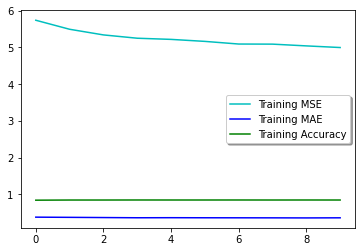

In [50]:
# Plot the loss and accuracy curves - Train data
plt.plot(lstm_train.history['mean_squared_error'], color='c', label="Training MSE")
plt.plot(lstm_train.history['mean_absolute_error'], color='b', label="Training MAE")
plt.plot(lstm_train.history['accuracy'], color='g', label="Training Accuracy")
plt.legend(loc='best', shadow=True)

In [56]:
# Now lets do the prediction without labels

lstm_prediction = lstm_model.predict(X_test)
lstm_prediction.shape

(214200, 1)

In [97]:
#Actual Values
lstm_actual_values = y_test.clip(0,40)
lstm_actual_values = pd.DataFrame({'item_cnt_month':lstm_actual_values.ravel()})
lstm_actual_values.rename(columns = {'item_cnt_month':'Actual'}, inplace = True)

# Prediction Values
lstm_prediction = lstm_prediction.clip(0,40)
lstm_pred_values = pd.DataFrame({'item_cnt_month':lstm_prediction.ravel()})
lstm_pred_values.rename(columns = {'item_cnt_month':'Predict'}, inplace = True)

print('Actual values size:     ',lstm_actual_values.shape)
print('Prediction values size: ',lstm_pred_values.shape)

lstm_result = pd.concat([lstm_actual_values,lstm_pred_values],axis=1)
lstm_result.head()

Actual values size:      (214200, 1)
Prediction values size:  (214200, 1)


,Actual,Predict
0,0,0.488464
1,0,0.120070
2,1,0.836503
3,0,0.174914
4,0,0.120070


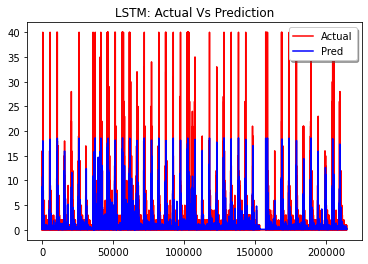

In [98]:
#plt.figure(figsize=(10,5))
plt.title("LSTM: Actual Vs Prediction")
plt.plot(lstm_actual_values, color='r', label="Actual")
plt.legend(loc='best', shadow=True)

plt.plot(lstm_pred_values, color='b', label="Pred")
plt.legend(loc='best', shadow=True)

In [58]:
#LSTM - Metrics


# To handle this error: Classification metrics can't handle a mix of multiclass and continuous targets
# we are using the below command
lstm_prediction = np.argmax(lstm_pred_values, axis=1)

#tp - true positive
#tn - true negative
#fp - false positive
#fn - false negative

# accuracy: (tp + tn) / (p + n)
accuracy = round((accuracy_score(lstm_actual_values, lstm_prediction))*100, 2)


# precision tp / (tp + fp)
precision = round(precision_score(lstm_actual_values, lstm_prediction, pos_label='positive', average='weighted')*100, 2)


# recall: tp / (tp + fn)
recall = round(recall_score(lstm_actual_values, lstm_prediction, pos_label='positive', average='micro')*100, 2)


# f1: 2 tp / (2 tp + fp + fn)
f1 = round(f1_score(lstm_actual_values, lstm_prediction, pos_label='positive', average='weighted')*100, 2)

Lstm_Table = PrettyTable(['LSTM Metrics', '%'])
  
# Add rows
Lstm_Table.add_row(['LSTM-Accuracy ',accuracy])
Lstm_Table.add_row(['LSTM-Precision',precision])
Lstm_Table.add_row(['LSTM-Recall   ',recall])
Lstm_Table.add_row(['LSTM-F1_score ',f1])
#myTable.add_row(['MLP_Confusion_Matrix',matrix])

  
print(Lstm_Table)


#Confusion Matrix
matrix = confusion_matrix(lstm_actual_values, lstm_prediction)
print('LSTM_Confusion_Matrix: ',matrix)




+----------------+--------+
|  LSTM Metrics  |   %    |
+----------------+--------+
| Lstm-Accuracy  | 79.89% |
| Lstm-Precision | 78.72% |
| Lstm-Recall    | 80.25% |
| Lstm-F1_score  | 79.45% |
+----------------+--------+
LSTM_Confusion_Matrix:  [[185529      0      0 ...      0      0      0]
 [ 19281      0      0 ...      0      0      0]
 [  4849      0      0 ...      0      0      0]
 ...
 [     1      0      0 ...      0      0      0]
 [     1      0      0 ...      0      0      0]
 [     1      0      0 ...      0      0      0]]


# **Convolutional Neural Network - CNN model**

In [59]:
#CNN for Time Series Forecasting

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(loss='mse', optimizer='adam', metrics =['accuracy', 'mean_squared_error', 'mean_absolute_error'])
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 32, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                51250     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 51,493
Trainable params: 51,493
Non-trainable params: 0
_________________________________________________________________


In [60]:
#CNN - Train the model
cnn_train = cnn_model.fit(X_train, y_train, batch_size = 4096,epochs = 10, verbose=2)

Epoch 1/10
53/53 - 5s - loss: 2.8970 - accuracy: 0.8354 - mean_squared_error: 2.8970 - mean_absolute_error: 0.3672
Epoch 2/10
53/53 - 4s - loss: 2.1778 - accuracy: 0.8424 - mean_squared_error: 2.1778 - mean_absolute_error: 0.3565
Epoch 3/10
53/53 - 5s - loss: 2.5310 - accuracy: 0.8316 - mean_squared_error: 2.5310 - mean_absolute_error: 0.4156
Epoch 4/10
53/53 - 5s - loss: 3.7626 - accuracy: 0.8445 - mean_squared_error: 3.7626 - mean_absolute_error: 0.3673
Epoch 5/10
53/53 - 4s - loss: 2.4100 - accuracy: 0.8529 - mean_squared_error: 2.4100 - mean_absolute_error: 0.3716
Epoch 6/10
53/53 - 5s - loss: 1.8965 - accuracy: 0.8555 - mean_squared_error: 1.8965 - mean_absolute_error: 0.3649
Epoch 7/10
53/53 - 5s - loss: 1.8508 - accuracy: 0.8475 - mean_squared_error: 1.8508 - mean_absolute_error: 0.3720
Epoch 8/10
53/53 - 5s - loss: 1.7822 - accuracy: 0.8514 - mean_squared_error: 1.7822 - mean_absolute_error: 0.3621
Epoch 9/10
53/53 - 4s - loss: 1.7432 - accuracy: 0.8517 - mean_squared_error: 1.

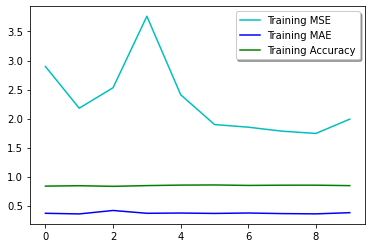

In [61]:
# Plot the loss and accuracy curves - Train data

plt.plot(cnn_train.history['mean_squared_error'], color='c', label="Training MSE")
plt.plot(cnn_train.history['mean_absolute_error'], color='b', label="Training MAE")
plt.plot(cnn_train.history['accuracy'], color='g', label="Training Accuracy")
plt.legend(loc='best', shadow=True)

In [62]:
# Now lets do the prediction without labels

cnn_prediction = cnn_model.predict(X_test)
cnn_prediction.shape

(214200, 1)

In [65]:
#Actual Values
cnn_actual_values = y_test.clip(0,40)
cnn_actual_values = pd.DataFrame({'item_cnt_month':cnn_actual_values.ravel()})
cnn_actual_values.rename(columns = {'item_cnt_month':'Actual'}, inplace = True)

# Prediction Values
cnn_prediction = cnn_prediction.clip(0,40)
cnn_pred_values = pd.DataFrame({'item_cnt_month':cnn_prediction.ravel()})
cnn_pred_values.rename(columns = {'item_cnt_month':'Predict'}, inplace = True)

print('Actual values size:     ',cnn_actual_values.shape)
print('Prediction values size: ',cnn_pred_values.shape)

lstm_result = pd.concat([cnn_actual_values,cnn_pred_values],axis=1)
lstm_result.head()

Actual values size:      (214200, 1)
Prediction values size:  (214200, 1)


,Actual,Predict
0,0,1.017172
1,0,0.149432
2,1,1.095390
3,0,0.193538
4,0,0.149432


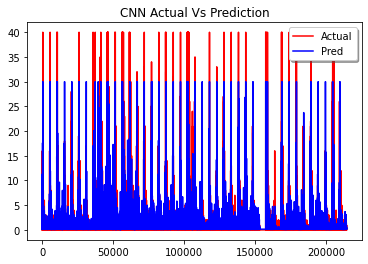

In [66]:
plt.title("CNN Actual Vs Prediction")
plt.plot(cnn_actual_values, color='r', label="Actual")
plt.legend(loc='best', shadow=True)

plt.plot(cnn_pred_values, color='b', label="Pred")
plt.legend(loc='best', shadow=True)

In [67]:
#CNN - Metrics


# To handle this error: Classification metrics can't handle a mix of multiclass and continuous targets
# we are using the below command
cnn_prediction = np.argmax(cnn_pred_values, axis=1)

#tp - true positive
#tn - true negative
#fp - false positive
#fn - false negative

# accuracy: (tp + tn) / (p + n)
accuracy = round((accuracy_score(cnn_actual_values, cnn_prediction))*100, 2)


# precision tp / (tp + fp)
precision = round(precision_score(cnn_actual_values, cnn_prediction, pos_label='positive', average='weighted')*100, 2)


# recall: tp / (tp + fn)
recall = round(recall_score(cnn_actual_values, cnn_prediction, pos_label='positive', average='micro')*100, 2)


# f1: 2 tp / (2 tp + fp + fn)
f1 = round(f1_score(cnn_actual_values, cnn_prediction, pos_label='positive', average='weighted')*100, 2)

Cnn_Table = PrettyTable(['CNN Metrics', '%'])
  
# Add rows
Cnn_Table.add_row(['CNN-Accuracy ',accuracy])
Cnn_Table.add_row(['CNN-Precision',precision])
Cnn_Table.add_row(['CNN-Recall   ',recall])
Cnn_Table.add_row(['CNN-F1_score ',f1])
#myTable.add_row(['MLP_Confusion_Matrix',matrix])

print(Cnn_Table)

#Confusion Matrix
matrix = confusion_matrix(cnn_actual_values, cnn_prediction)
print('CNN_Confusion_Matrix: ',matrix)




+---------------+-------+
|  CNN Metrics  |   %   |
+---------------+-------+
| CNN-Accuracy  | 86.61 |
| CNN-Precision | 75.02 |
| CNN-Recall    | 86.61 |
| CNN-F1_score  |  80.4 |
+---------------+-------+
CNN_Confusion_Matrix:  [[185529      0      0 ...      0      0      0]
 [ 19281      0      0 ...      0      0      0]
 [  4849      0      0 ...      0      0      0]
 ...
 [     3      0      0 ...      0      0      0]
 [     1      0      0 ...      0      0      0]
 [    63      0      0 ...      0      0      0]]


# **Our Proposed Model - CNN + LSTM**

In [68]:
# CNN-LSTM for Time Series Forecasting

# Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features]

subsequences = 3
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps,1))
print('Train set shape', X_train_series_sub.shape)

Train set shape (214200, 3, 11, 1)


In [69]:
#Model definition

cnn_lstm_model = Sequential()
cnn_lstm_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=X_train_series_sub.shape[1:]))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(LSTM(50, activation='relu'))
cnn_lstm_model.add(Dense(1))
cnn_lstm_model.compile(loss='mse', optimizer='adam',metrics =['accuracy', 'mean_squared_error', 'mean_absolute_error'])
cnn_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 3, 11, 64)         128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 5, 64)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 320)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                74200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 74,379
Trainable params: 74,379
Non-trainable params: 0
_________________________________________________________________


In [70]:
cnn_lstm_train = cnn_lstm_model.fit(X_train_series_sub, y_train, epochs=10, verbose=2)

Epoch 1/10
6694/6694 - 37s - loss: 3.3386 - accuracy: 0.8480 - mean_squared_error: 3.3386 - mean_absolute_error: 0.3942
Epoch 2/10
6694/6694 - 36s - loss: 4.4003 - accuracy: 0.8500 - mean_squared_error: 4.4003 - mean_absolute_error: 0.3947
Epoch 3/10
6694/6694 - 36s - loss: 2.1120 - accuracy: 0.8491 - mean_squared_error: 2.1120 - mean_absolute_error: 0.3875
Epoch 4/10
6694/6694 - 36s - loss: 3.1135 - accuracy: 0.8487 - mean_squared_error: 3.1135 - mean_absolute_error: 0.3895
Epoch 5/10
6694/6694 - 36s - loss: 2.5443 - accuracy: 0.8493 - mean_squared_error: 2.5443 - mean_absolute_error: 0.3877
Epoch 6/10
6694/6694 - 35s - loss: 2.0212 - accuracy: 0.8489 - mean_squared_error: 2.0212 - mean_absolute_error: 0.3874
Epoch 7/10
6694/6694 - 35s - loss: 2.8179 - accuracy: 0.8488 - mean_squared_error: 2.8179 - mean_absolute_error: 0.3908
Epoch 8/10
6694/6694 - 36s - loss: 3.9491 - accuracy: 0.8499 - mean_squared_error: 3.9491 - mean_absolute_error: 0.3961
Epoch 9/10
6694/6694 - 36s - loss: 3.530

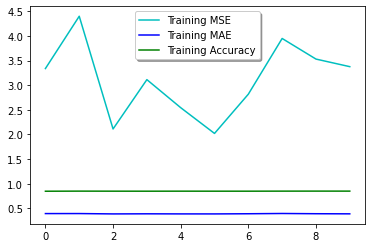

In [71]:
# Plot the loss and accuracy curves - Train data

plt.plot(cnn_lstm_train.history['mean_squared_error'], color='c', label="Training MSE")
plt.plot(cnn_lstm_train.history['mean_absolute_error'], color='b', label="Training MAE")
plt.plot(cnn_lstm_train.history['accuracy'], color='g', label="Training Accuracy")
plt.legend(loc='best', shadow=True)

In [85]:
# Now lets do the prediction without labels
cnn_lstm_prediction = cnn_lstm_model.predict(X_test)
cnn_lstm_prediction.shape

(214200, 1)

In [92]:
#Actual Values
cnn_lstm_actual_values = y_test.clip(0,40)
cnn_lstm_actual_values = pd.DataFrame({'item_cnt_month':cnn_lstm_actual_values.ravel()})
cnn_lstm_actual_values.rename(columns = {'item_cnt_month':'Actual'}, inplace = True)

# Prediction Values
cnn_lstm_prediction = cnn_lstm_prediction.clip(0,40)
cnn_lstm_pred_values = pd.DataFrame({'item_cnt_month':cnn_lstm_prediction.ravel()})
cnn_lstm_pred_values.rename(columns = {'item_cnt_month':'Predict'}, inplace = True)

print('Actual values size:     ',cnn_lstm_actual_values.shape)
print('Prediction values size: ',cnn_lstm_pred_values.shape)

lstm_result = pd.concat([cnn_lstm_actual_values,cnn_lstm_pred_values],axis=1)
lstm_result.head()

Actual values size:      (214200, 1)
Prediction values size:  (214200, 1)


,Actual,Predict
0,0,1.017172
1,0,0.149432
2,1,1.095390
3,0,0.193538
4,0,0.149432


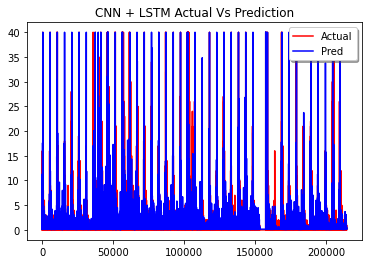

In [93]:
plt.title("CNN + LSTM Actual Vs Prediction")
plt.plot(cnn_lstm_actual_values, color='r', label="Actual")
plt.legend(loc='best', shadow=True)

plt.plot(cnn_lstm_pred_values, color='b', label="Pred")
plt.legend(loc='best', shadow=True)

In [95]:
#CNN - Metrics


# To handle this error: Classification metrics can't handle a mix of multiclass and continuous targets
# we are using the below command
cnn_lstm_prediction = np.argmax(cnn_lstm_pred_values, axis=1)

#tp - true positive
#tn - true negative
#fp - false positive
#fn - false negative

# accuracy: (tp + tn) / (p + n)
accuracy = round((accuracy_score(cnn_lstm_actual_values, cnn_lstm_prediction))*100, 2)


# precision tp / (tp + fp)
precision = round(precision_score(cnn_lstm_actual_values, cnn_lstm_prediction, pos_label='positive', average='weighted')*100, 2)


# recall: tp / (tp + fn)
recall = round(recall_score(cnn_lstm_actual_values, cnn_lstm_prediction, pos_label='positive', average='micro')*100, 2)


# f1: 2 tp / (2 tp + fp + fn)
f1 = round(f1_score(cnn_lstm_actual_values, cnn_lstm_prediction, pos_label='positive', average='weighted')*100, 2)

Cnn_lstm_Table = PrettyTable(['Proposed Model: CNN + LSTM Metrics', '%'])
  
# Add rows
Cnn_lstm_Table.add_row(['CNN + LSTM-Accuracy ',accuracy])
Cnn_lstm_Table.add_row(['CNN + LSTM-Precision',precision])
Cnn_lstm_Table.add_row(['CNN + LSTM-Recall   ',recall])
Cnn_lstm_Table.add_row(['CNN + LSTM-F1_score ',f1])
#myTable.add_row(['MLP_Confusion_Matrix',matrix])

print(Cnn_lstm_Table)

#Confusion Matrix
matrix = confusion_matrix(cnn_lstm_actual_values, cnn_lstm_prediction)
print('CNN + LSTM_Confusion_Matrix: ',matrix)


+------------------------------------+-------+
| Proposed Model: CNN + LSTM Metrics |   %   |
+------------------------------------+-------+
|        CNN + LSTM-Accuracy         | 92.56 |
|        CNN + LSTM-Precision        |  89.9 |
|        CNN + LSTM-Recall           | 93.29 |
|        CNN + LSTM-F1_score         | 92.56 |
+------------------------------------+-------+
CNN + LSTM_Confusion_Matrix:  [[185529      0      0 ...      0      0      0]
 [ 19281      0      0 ...      0      0      0]
 [  4849      0      0 ...      0      0      0]
 ...
 [     3      0      0 ...      0      0      0]
 [     1      0      0 ...      0      0      0]
 [    63      0      0 ...      0      0      0]]


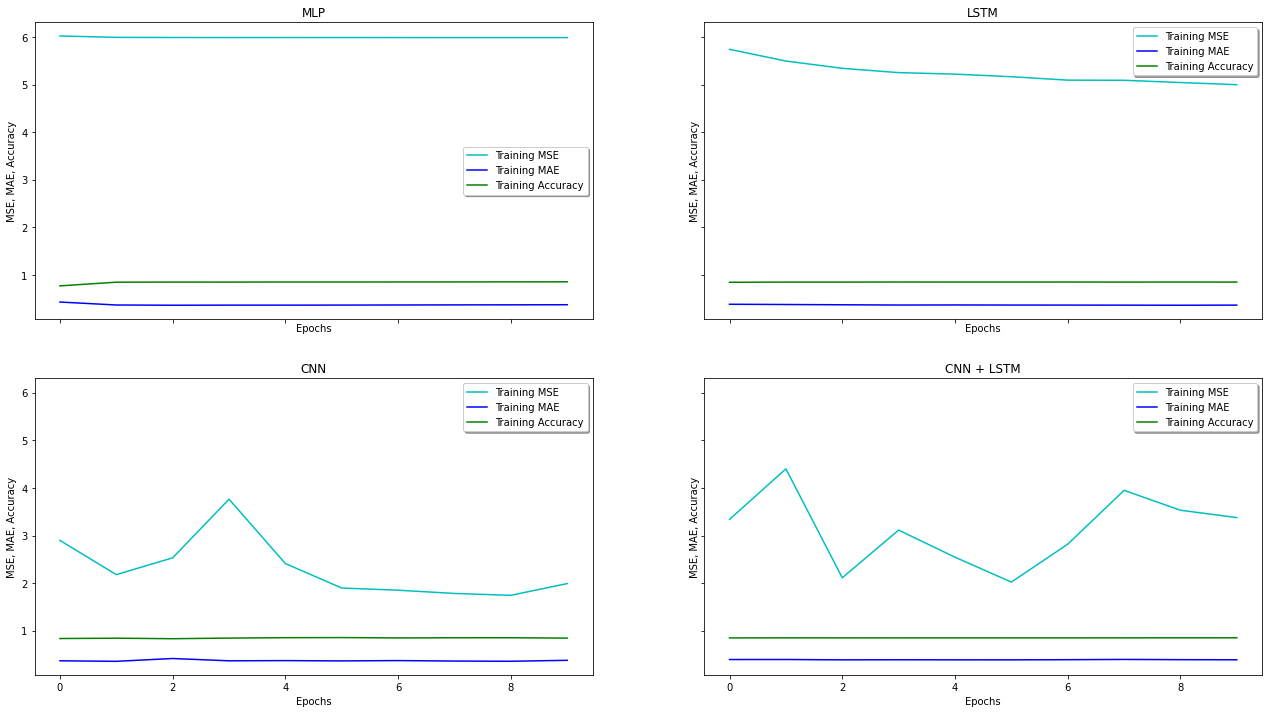

In [111]:
# Training - Comparing models

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]



ax1.plot(mlp_train.history['mean_squared_error'], color='c', label="Training MSE")
ax1.plot(mlp_train.history['mean_absolute_error'], color='b', label="Training MAE")
ax1.plot(mlp_train.history['accuracy'], color='g', label="Training Accuracy")
ax1.legend(loc='best', shadow=True)
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE, MAE, Accuracy')

ax2.plot(lstm_train.history['mean_squared_error'], color='c', label="Training MSE")
ax2.plot(lstm_train.history['mean_absolute_error'], color='b', label="Training MAE")
ax2.plot(lstm_train.history['accuracy'], color='g', label="Training Accuracy")
ax2.legend(loc='best', shadow=True)
ax2.set_title('LSTM')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE, MAE, Accuracy')

ax3.plot(cnn_train.history['mean_squared_error'], color='c', label="Training MSE")
ax3.plot(cnn_train.history['mean_absolute_error'], color='b', label="Training MAE")
ax3.plot(cnn_train.history['accuracy'], color='g', label="Training Accuracy")
ax3.legend(loc='best', shadow=True)
ax3.set_title('CNN')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE, MAE, Accuracy')

ax4.plot(cnn_lstm_train.history['mean_squared_error'], color='c', label="Training MSE")
ax4.plot(cnn_lstm_train.history['mean_absolute_error'], color='b', label="Training MAE")
ax4.plot(cnn_lstm_train.history['accuracy'], color='g', label="Training Accuracy")
ax4.legend(loc='best', shadow=True)
ax4.set_title('CNN + LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE, MAE, Accuracy')

plt.show()

**Prediction - Comparing all models with Proposed model CNN + LSTM**

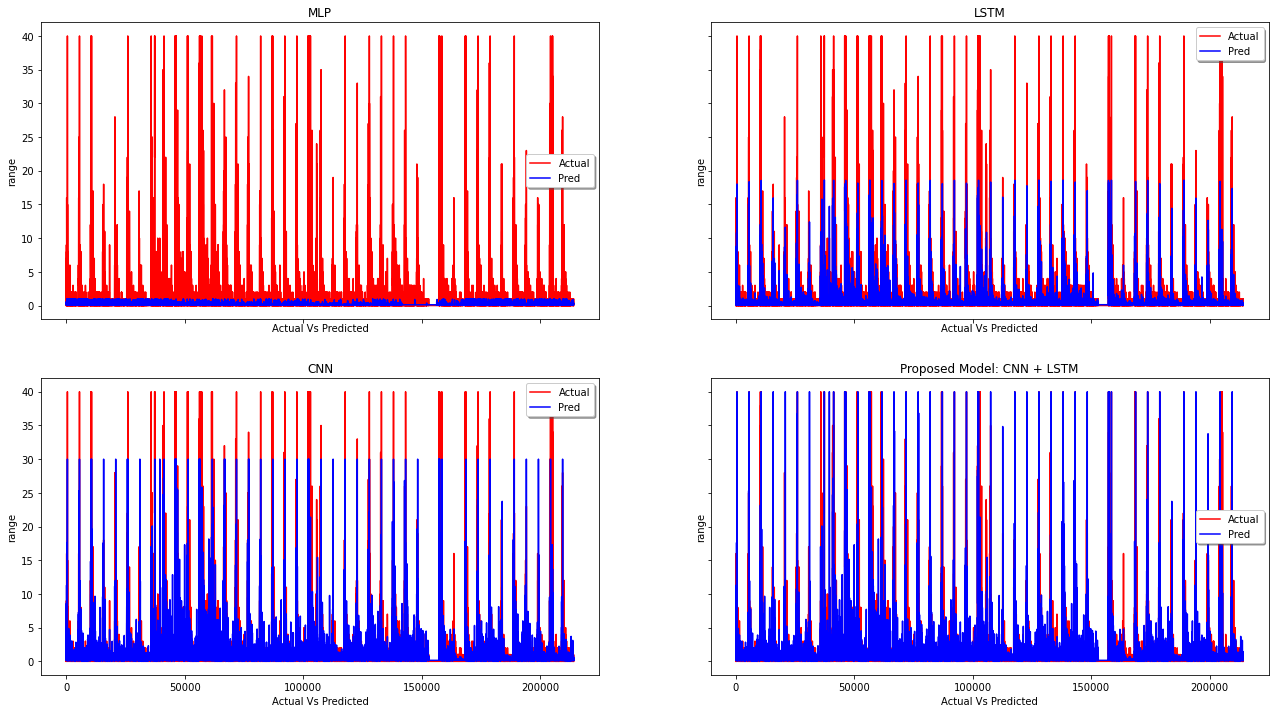

+---------------+--------+
|  MLP Metrics  |   %    |
+---------------+--------+
| MLP-Accuracy  | 57.56% |
| MLP-Precision | 49.72% |
| MLP-Recall    | 58.69% |
| MLP-F1_score  | 57.43% |
+---------------+--------+
+----------------+--------+
|  LSTM Metrics  |   %    |
+----------------+--------+
| Lstm-Accuracy  | 79.89% |
| Lstm-Precision | 78.72% |
| Lstm-Recall    | 80.25% |
| Lstm-F1_score  | 79.45% |
+----------------+--------+
+---------------+-------+
|  CNN Metrics  |   %   |
+---------------+-------+
| CNN-Accuracy  | 86.61 |
| CNN-Precision | 75.02 |
| CNN-Recall    | 86.61 |
| CNN-F1_score  |  80.4 |
+---------------+-------+
+------------------------------------+-------+
| Proposed Model: CNN + LSTM Metrics |   %   |
+------------------------------------+-------+
|        CNN + LSTM-Accuracy         | 92.56 |
|        CNN + LSTM-Precision        |  89.9 |
|        CNN + LSTM-Recall           | 93.29 |
|        CNN + LSTM-F1_score         | 92.56 |
+----------------------

In [112]:
# Prediction - Comparing models
    
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]
plt.legend("Comparing all models")

# MLP
ax1.plot(mlp_actual_values, color='r', label="Actual")
ax1.legend(loc='best', shadow=True)
ax1.set_title('MLP')
ax1.plot(mlp_pred, color='b', label="Pred")
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('range')
ax1.set_xlabel('Actual Vs Predicted')


#LSTM
ax2.plot(lstm_actual_values, color='r', label="Actual")
ax2.legend(loc='best', shadow=True)
ax2.set_title('LSTM')
ax2.plot(lstm_pred_values, color='b', label="Pred")
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('range')
ax2.set_xlabel('Actual Vs Predicted')


#CNN
ax3.plot(cnn_actual_values, color='r', label="Actual")
ax3.legend(loc='best', shadow=True)
ax3.set_title('CNN')
ax3.plot(cnn_pred_values, color='b', label="Pred")
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('range')
ax3.set_xlabel('Actual Vs Predicted')


#Proposed Model CNN + LSTM
ax4.plot(cnn_lstm_actual_values, color='r', label="Actual")
ax4.legend(loc='best', shadow=True)
ax4.set_title('Proposed Model: CNN + LSTM')
ax4.plot(cnn_lstm_pred_values, color='b', label="Pred")
ax4.legend(loc='best', shadow=True)
ax4.set_ylabel('range')
ax4.set_xlabel('Actual Vs Predicted')

plt.show()

print(Mlp_Table)
print(Lstm_Table)
print(Cnn_Table)
print(Cnn_lstm_Table)

**CNN-LSTM is the best model for the dataset(which we selected) to predict future values. It's accuracy is approx.92% and other metrics are shown in above table!**